# Rによる気象データ収集
---
気象庁のデータをゲットする方法を考えます。

## 参考にしたサイト
この場を借りて。
- [気象統計情報から過去の気象データを取得](https://gist.github.com/tayohei/2281631)

## パッケージのインストール
XMLのデータを使えるようにしてみます。

docker中でのパッケージのインストールが無事できました。install.packages("XML")　だけではダメでした。

できたところで，とりあえず1のプログラムを動かしてみます。

In [4]:
# https://gist.github.com/tayohei/2281631
# より。

# 気象庁の気象統計情報の過去の気象データを引っ張ってくる。（月単位）
# 観測地点の block_no と年月が必要、block_idは下記URLから
# http://www.data.jma.go.jp/obd/stats/etrn/index.php
# 県→地域と選択した時のURLパラメータのblock_noを利用
# windows以外だと文字化けるかも。

library("XML")

getWeather <- function(block,year,month,addDate=T){
    # 気象庁からデータを引っ張ってくる
    # args
    #	block: 観測所のID
    #	year : 年（1872～）
    #	month: 月（1-12）
    #	addDate:出力データに日付の列を追加する
    # return
    #	引っ張ってきた表のdata.frame形式
    url <- "http://www.data.jma.go.jp/obd/stats/etrn/view/daily_s1.php";
    url <- paste(url,"?block_no=",block,"&year=",year,"&month=",month,"&elm=daily",sep="");
    tmp <- xpathSApply(htmlParse(url,encoding="UTF-8"),'//td[@class="data_0_0"]',xmlValue);
    tmp <- data.frame(matrix(tmp,ncol=20,byrow=T));
    # 決め打ちで数値の列は数値に変換
    numcol = c(1:12,14,16:18);
    for(i in numcol){
        tmp[,i] <- as.numeric(as.character(sub("]|)","",tmp[,i])));
    }
    # 列名つける
    colnames(tmp) <- c(
        'press.land','press.sea',
        'rain.sum','rain.max1h','rain.max10m',
        'temp.ave','temp.max','temp.min',
        'hygro.ave','hygro.min',
        'wind.ave','wind.max.v','wind.max.d','wind.max_d.v','wind.max_d.d',
        'daylight',
        'snow.sum','snow.depth',
        'weather.am','weather.pm'
    );
    if(addDate){
        tmp <- cbind(
            year*10000+month*100+(1:nrow(tmp)),
            tmp
            );
        colnames(tmp)[1] <- "date";
    }
    return(tmp);
}


getWeatherAB <- function(block,a.year,a.month,b.year,b.month,addDate=T){
    # 指定した期間での気象情報を出力
    # args
    #	block: 観測所のID
    #	a.year : 開始年（1872～）,	a.month: 月（1-12）
    #	b.year : 終了年（1872～）,	b.month: 月（1-12）
    #	addDate: 結果に日付列を追加するかどうか？
    # return
    #	引っ張ってきた表のdata.frame形式を繋げた形
    if( (a.year*100+a.month)>(b.year*100+b.month) ){
        stop("開始よりも終了が前になってます");
    }
    tmp <- NULL;
    while(a.year<=b.year && a.month<=b.month){
        print(a.year*100+a.month);
        tmp <- rbind(tmp,getWeather(block,a.year,a.month,addDate));
        if(a.month==12){
            a.year  <- a.year+1;
            a.month <- 1;
        }else{
            a.month <- a.month+1;
        }
    }
    return(tmp);
}

SensibleTemp <- function(t,h){
    # おまけ、体感温度（ミスナールの体感温度）
    # args
    #	t : 気温
    #	h : 湿度
    return((t-1/2.3)*(t-10)*(0.8-h/100));
}

DiscomfortIndex <-function(t,h,cut=F){
    # おまけ、不快指数
    # args
    #	t : 気温
    #	h : 湿度
    #	cut : １～８までに分けるかどうたら。
    if(cut){
        return(cut(breaks=c(0,55,60,65,70,75,80,85,100),50:95,1:8));
    }else{
        return(0.81*t+0.01*h*(0.99*t-14.3)+46.3);
    }
}

よし。一発OK。
使ってみます。

In [5]:
getWeather(47662,2000,10,addDate=T)

ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 2, 0


ん？ダメ。

In [6]:
url <- "http://www.data.jma.go.jp/obd/stats/etrn/view/daily_s1.php";
url <- paste(url,"?block_no=",block,"&year=",year,"&month=",month,"&elm=daily",sep="");
tmp <- xpathSApply(htmlParse(url,encoding="UTF-8"),'//td[@class="data_0_0"]',xmlValue);
tmp <- data.frame(matrix(tmp,ncol=20,byrow=T));

numcol = c(1:12,14,16:18);
colnames(tmp) <- c(
    'press.land','press.sea',
    'rain.sum','rain.max1h','rain.max10m',
    'temp.ave','temp.max','temp.min',
    'hygro.ave','hygro.min',
    'wind.ave','wind.max.v','wind.max.d','wind.max_d.v','wind.max_d.d',
    'daylight',
    'snow.sum','snow.depth',
    'weather.am','weather.pm'
);
for(i in numcol){
    tmp[,i] <- as.numeric(as.character(sub("]|)","",tmp[,i])));
}


In [7]:
freq = "10min" # "daily" or "hourly" or "10min", 
prec_no = "44"
block = "47662"
year = "2011"
month = "06"
day = "24"

In [8]:
# http://www.data.jma.go.jp/obd/stats/etrn/view/hourly_s1.php?prec_no=44&block_no=47662&year=2016&month=1&day=1&view=

# http://www.data.jma.go.jp/obd/stats/etrn/view/10min_s1.php?prec_no=44&block_no=47662&year=2011&month=06&day=24&view=p1

url_ex <- "http://www.data.jma.go.jp/obd/stats/etrn/view/hourly_s1.php?prec_no=44&block_no=47662&year=2011&month=06&day=24&view="
url <- "http://www.data.jma.go.jp/obd/stats/etrn/view/";
url <- paste(url, freq,"_s1.php?prec_no=",prec_no,"&block_no=",block,"&year=",year,"&month=",month,"&day=",day,"&view=",sep="");


In [9]:
url_ex
url

[1] "http://www.data.jma.go.jp/obd/stats/etrn/view/hourly_s1.php?prec_no=44&block_no=47662&year=2011&month=06&day=24&view="

[1] "http://www.data.jma.go.jp/obd/stats/etrn/view/10min_s1.php?prec_no=44&block_no=47662&year=2011&month=06&day=24&view="

In [10]:
tmp <- xpathSApply(htmlParse(url,encoding="UTF-8"),'//td[@class="data_0_0"]',xmlValue);



In [11]:
length(tmp)

[1] 1440

In [12]:
# htmlParse(url,encoding="UTF-8")
tmp <- matrix(tmp, 10, length(tmp)/10)

In [13]:
dim(tmp)

[1]  10 144

In [14]:
tmp

998.4,998.3,998.3,998.2,998.2,998.3,998.2,998.2,998.2,998.3,⋯,1002.6,1002.6,1002.6,1002.8,1002.9,1003.0,1003.2,1003.2,1003.2,1003.1
1002.5,1002.4,1002.4,1002.3,1002.3,1002.4,1002.3,1002.3,1002.3,1002.4,⋯,1006.7,1006.7,1006.7,1006.9,1007.0,1007.1,1007.3,1007.3,1007.3,1007.2
--,--,--,--,--,--,--,--,--,--,⋯,--,--,--,--,--,--,--,--,--,--
27.3,27.2,27.4,27.4,27.3,27.4,27.3,27.2,27.1,27.1,⋯,27.9,28.0,28.0,28.1,28.2,28.1,28.0,27.7,27.8,27.8
68,68,67,67,67,66,67,67,67,67,⋯,67,67,66,66,65,66,66,67,67,67
6.2,6.8,6.0,5.5,5.1,6.1,5.8,5.3,5.6,8.5,⋯,4.5,5.0,4.9,4.3,4.1,3.5,3.0,3.3,2.8,4.8
南南西,南南西,南南西,南南西,南南西,南南西,南南西,南南西,南南西,南西,⋯,南南西,南南西,南南西,南南西,南南西,南西,西南西,南西,南西,南南西
12.7,11.7,10.3,9.1,9.7,12.1,11.9,10.7,11.7,15.4,⋯,8.5,8.7,8.7,8.0,8.1,8.6,6.8,6.6,6.7,9.5
南南西,南西,南南西,南南西,南南西,南西,南南西,南西,南南西,南西,⋯,南南西,南,南南西,南南西,西南西,南南西,西南西,南南西,南西,南西
,,,,,,,,,,⋯,,,,,,,,,,


ここから本ちゃん

In [ ]:
install.packages("XML", repos = "http://cran.us.r-project.org")

In [54]:
dayPerMonth <- function(date_)
{
    #該当月の月初日
    startOfMonth <- as.Date(format(date_,"%Y%m01"),"%Y%m%d")
    #次月の月初日
    startOfNextMonth <- as.Date(format(startOfMonth+31,"%Y%m01"),"%Y%m%d")
    #一日前が該当月の月末日
    return(as.numeric(startOfNextMonth-startOfMonth))
    #    return(startOfNextMonth-1)
}

In [55]:
dayPerMonth(as.Date("2016-10-01"))

[1] 31

In [80]:
freq = "10min" # "daily" or "hourly" or "10min", 
prec_no = "44"
block = "47662"
year = "2011"
month = "06"
#day = 24
dataType = 10

if(freq == "10min"){
    firstTime = " 00:10:00"
}else if(freq == "hourly"){
    firstTime = " 01:00:00"
}else{
    firstTime = " 00:00:00"
};

#Data <- matrix(nrow = dataType, ncol = 1)
Data <- NULL;
days = dayPerMonth(as.Date(paste(year, "-",month,"-01", sep="")))

for (day in 1 : days){
    url <- "http://www.data.jma.go.jp/obd/stats/etrn/view/";
    url <- paste(url, freq,"_s1.php?prec_no=",prec_no,"&block_no=",block,"&year=",year,"&month=",month,"&day=",day,"&view=",sep="");
    tmp <- xpathSApply(htmlParse(url,encoding="UTF-8"),'//td[@class="data_0_0"]',xmlValue);
    tmp <- t(matrix(tmp, dataType, length(tmp)/dataType));
    time <- as.POSIXlt(paste(year,"-",month,"-",day,firstTime, sep="")) + seq(0,(24*60*60)-1,by=600);
    tmp <- cbind(time,tmp);
    Data <- rbind(Data, tmp)        
}



In [81]:
dim(Data)

[1] 4320   11

Warning message:
In xy.coords(x, y, xlabel, ylabel, log): NAs introduced by coercion

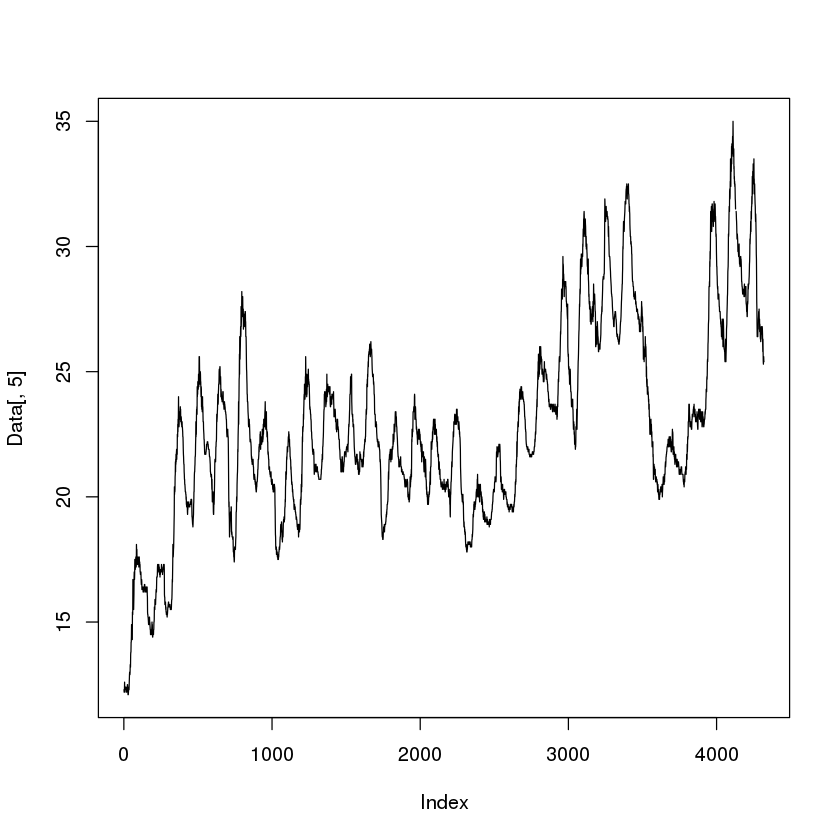

In [85]:
plot(Data[,5],type="l")

In [86]:
write.csv(Data, "test.csv", quote=FALSE, row.names=FALSE)